**Description**: Analyzes BERT *or* GPT-2 accuracies for a given number of test
observations (200 or 500).

**Estimated runtime**: ~1 hour (Multi-core isn't working on my machine. Set
`cores=4` in the `model.fit` call if it works for you.)

In [1]:
import os
from typing import Literal

import seaborn as sns

import utils

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
sns.set_theme(style="darkgrid")

# Configuration

Which model and which number of test observations do you want to analyze?

In [3]:
model: Literal["bert", "gpt2"] = "gpt2"
num_test: Literal[200, 500] = 200

# Load data

In [4]:
accuracies_dir = os.path.join("accuracies_from_paper", str(num_test), model)
accuracy_df = utils.load_accuracies(accuracies_dir)
num_correct_df = utils.accuracies_to_num_correct(accuracy_df, num_test)

In [5]:
equation = "p(num_correct, num_test) ~ method + (1|dataset/pair)"

# Plot

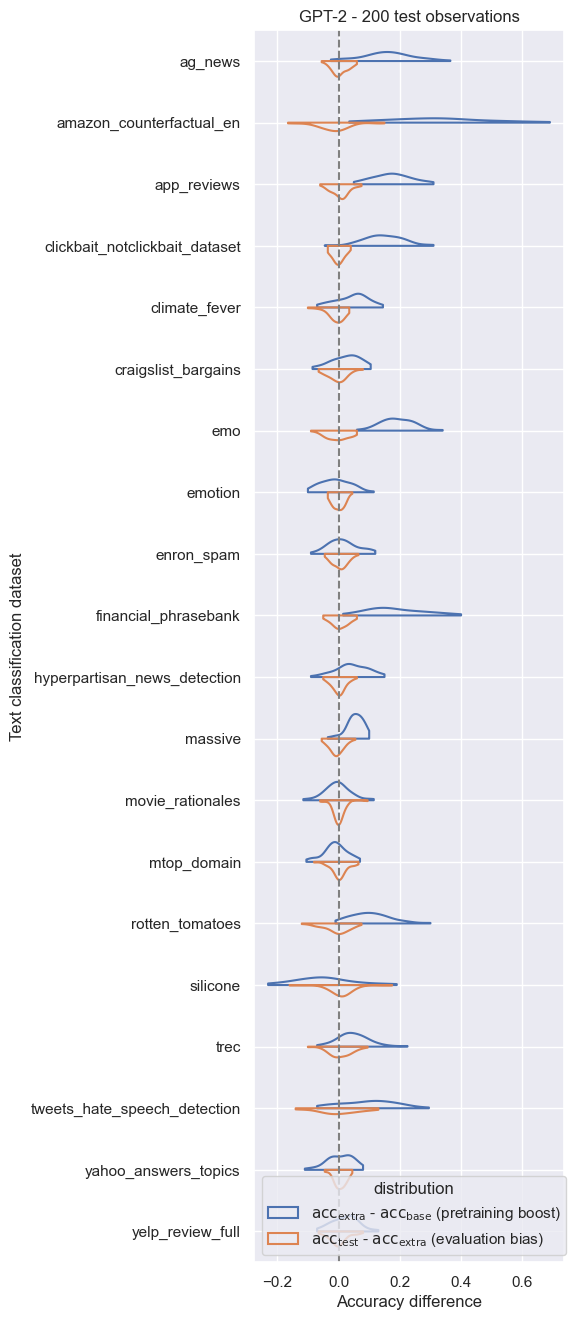

In [6]:
ax = utils.violin_plot(
    accuracy_df, title=f"{utils.lm_type_to_name[model]} - {num_test} test observations"
)
# sns.move_legend(
#     ax, "upper center",
#     bbox_to_anchor=(.1, 1), ncol=2, title=None, frameon=False,
# )  # not sure why this doesn't work

# Does pretraining help?

This is our control.

In [7]:
utils.eda(accuracy_df, treatment="extra", control="base")

Overall difference:
┌──────────┬──────────┐
│ mean     ┆ std      │
╞══════════╪══════════╡
│ 0.078185 ┆ 0.063275 │
└──────────┴──────────┘


dataset,mean,std
"""ag_news""",0.1575,0.083031
"""amazon_counter…",0.3212,0.158721
"""app_reviews""",0.1751,0.063676
"""clickbait_notc…",0.1475,0.064833
"""climate_fever""",0.0431,0.053202
"""craigslist_bar…",0.0245,0.047297
"""emo""",0.1912,0.053515
"""emotion""",-0.0095,0.048311
"""enron_spam""",0.0154,0.048243
"""financial_phra…",0.1858,0.094196


/Users/kdubey/Envs/pretrain/lib/python3.11/site-packages/formulae/terms/call.py:108: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_string_dtype(x) or is_categorical_dtype(x) or isinstance(x, CategoricalBox):
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [Intercept, method, 1|dataset_sigma, 1|dataset_offset, 1|dataset:pair_sigma, 1|dataset:pair_offset]


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 248 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
method[extra],0.232,0.007,0.218,0.244,0.0,0.0,927.0,761.0,NaN


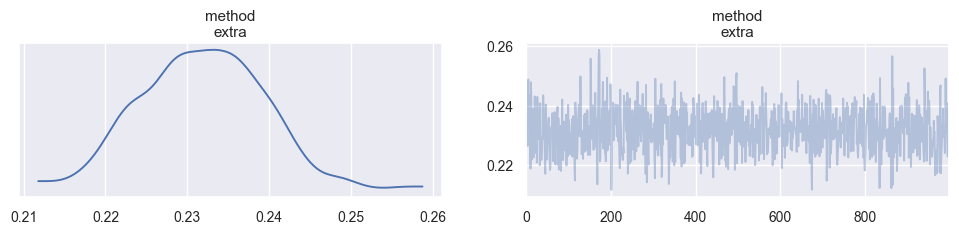

In [8]:
model_control, summary_control, az_summary_control = utils.stat_model(
    num_correct_df, treatment="extra", control="base", equation=equation, chains=1
)

In [13]:
print(model_control)

       Formula: p(num_correct, num_test) ~ method + (1|dataset/pair)
        Family: binomial
          Link: p = logit
  Observations: 800
        Priors: 
    target = p
        Common-level effects
            Intercept ~ Normal(mu: 0.0, sigma: 1.0)
            method ~ Normal(mu: 0.0, sigma: 1.0)
        
        Group-level effects
            1|dataset ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 1.0))
            1|dataset:pair ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 1.0))
------
* To see a plot of the priors call the .plot_priors() method.
* To see a summary or plot of the posterior pass the object returned by .fit() to az.summary() or az.plot_trace()


Solid evidence that pretraining helps. There's an effect to detect.

# Does pretraining on test cause bias?

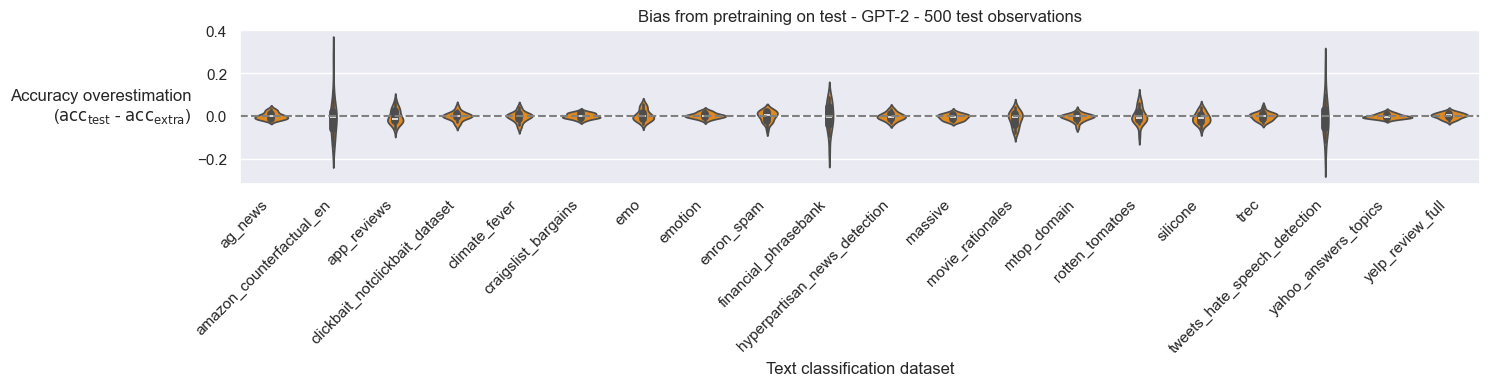

Overall difference:
┌──────────┬──────────┐
│ mean     ┆ std      │
╞══════════╪══════════╡
│ -0.00266 ┆ 0.030274 │
└──────────┴──────────┘


dataset,mean,std
"""ag_news""",0.0003,0.015712
"""amazon_counter…",-0.0055,0.092187
"""app_reviews""",-0.0025,0.033302
"""clickbait_notc…",-0.0007,0.019919
"""climate_fever""",-0.0032,0.022909
"""craigslist_bar…",0.0004,0.012458
"""emo""",0.0036,0.025887
"""emotion""",0.0019,0.01254
"""enron_spam""",-0.0014,0.025316
"""financial_phra…",-0.0042,0.064814


In [10]:
title = " - ".join(
    [
        "Bias from pretraining on test",
        utils.lm_type_to_name[model],
        f"{num_test} test observations",
    ]
)
ylabel = "Accuracy overestimation"
ylabel_kwargs = dict(rotation="horizontal", ha="right", va="center")
utils.eda(
    accuracy_df,
    treatment="test",
    control="extra",
    title=title,
    color="darkorange",
    ylabel=ylabel,
    **ylabel_kwargs,
)

/Users/kdubey/Envs/pretrain/lib/python3.11/site-packages/formulae/terms/call.py:108: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_string_dtype(x) or is_categorical_dtype(x) or isinstance(x, CategoricalBox):
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [Intercept, method, 1|dataset_sigma, 1|dataset_offset, 1|dataset:pair_sigma, 1|dataset:pair_offset]


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 451 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
method[test],-0.014,0.007,-0.026,0.0,0.0,0.0,2417.0,600.0,NaN


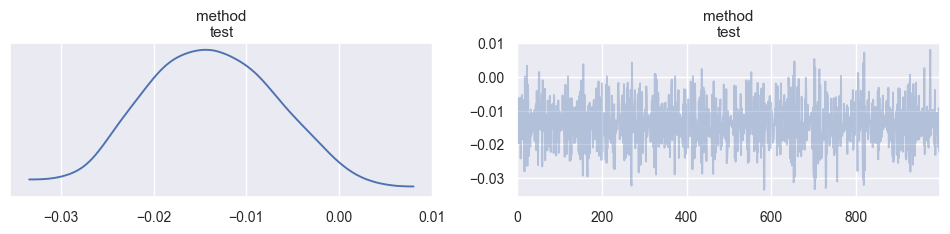

In [11]:
model_bias, summary_bias, az_summary_bias = utils.stat_model(
    num_correct_df, treatment="test", control="extra", equation=equation, chains=1
)

In [12]:
print(model_bias)

       Formula: p(num_correct, num_test) ~ method + (1|dataset/pair)
        Family: binomial
          Link: p = logit
  Observations: 800
        Priors: 
    target = p
        Common-level effects
            Intercept ~ Normal(mu: 0.0, sigma: 1.0)
            method ~ Normal(mu: 0.0, sigma: 1.0)
        
        Group-level effects
            1|dataset ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 1.0))
            1|dataset:pair ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 1.0))
------
* To see a plot of the priors call the .plot_priors() method.
* To see a summary or plot of the posterior pass the object returned by .fit() to az.summary() or az.plot_trace()
